In [14]:
import pandas as pd
import re
import os
from utilities import read_xml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
#from datasets import Dataset, DatasetDict
#import torch
#from scipy.cluster.hierarchy import linkage
#import plotly.figure_factory as ff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
from utilities import read_xml, plot_two, plot_three, clean_description

# Tokenizing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


"""from neo4j import GraphDatabase
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier"""
from utilities import read_xml, plot_two, plot_three, clean_description



In [15]:
# Load XML files
PATH_DEV = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_dev.txt')
PATH_TEST = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_test.txt')
PATH_TRAIN = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_train.txt')

df = pd.concat([read_xml(PATH_TRAIN), read_xml(PATH_TEST), read_xml(PATH_DEV)])

## Preprocessing Label

Extract reduced topics from topiclist



In [16]:
reduced_topics = [
    "Fiction", "Children’s Books", "Nonfiction",
    "Poetry", "Humor", "Classics", "Young Adult"
]

df['TOPICS_SPLIT'] = df['TOPICS'].apply(lambda x: sorted(list(set(i.strip() for i in re.split(r'[,\s]{2,}', x)))))

def assign_primary_topic(topic_string):
    list_return = []
    for reduced_topic in reduced_topics:
        for t in topic_string:
            if reduced_topic.lower() in t.lower():
                list_return.append(reduced_topic)
    return list(set(sorted(list_return)))

df['TOPIC_MAIN'] = df['TOPICS_SPLIT'].apply(assign_primary_topic)
if any(df['TOPIC_MAIN'].apply(lambda x: len(x) == 0)):
    raise Exception('TOPIC_MAIN is somewhere empty')

In [17]:
df['TOPIC_MAIN'].head(10)

0     [Fiction, Nonfiction]
1                 [Fiction]
2        [Children’s Books]
3                 [Fiction]
4    [Young Adult, Fiction]
5        [Children’s Books]
6                 [Fiction]
7                 [Fiction]
8     [Fiction, Nonfiction]
9                 [Fiction]
Name: TOPIC_MAIN, dtype: object

## Prepreprocessing Blurbs

Remove Errors in Origdata

In [18]:
df['DESCRIPTION'] = df['DESCRIPTION'].fillna('').apply(clean_description)

## Preprocessing

Remove Stopwords, Tokenization and Stemmer

**Tokenization** with Nltk and Spacy


In [19]:
stemmer = PorterStemmer()
def preprocess_text(text, stopwords):
    # Tokenization
    tokens = word_tokenize(text.lower())  # Lowercasing and tokenizing
    # Removing stop words and non-alphabetical characters
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]
    # Applying stemming on the filtered tokens
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return " ".join(stemmed_tokens)

# NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk_stopwords = set(stopwords.words('english'))

# Spacy
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = set(nlp.Defaults.stop_words)


# Apply preprocessing to the book descriptions
df['DESCRIPTION_CLEAN_NLTK'] = df['DESCRIPTION'].apply(preprocess_text, stopwords=nltk_stopwords)
df['DESCRIPTION_CLEAN_SPACY'] = df['DESCRIPTION'].apply(preprocess_text, stopwords=spacy_stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Oliver\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oliver\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Oliver\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Vektorising

with TF-IDF, Word2Vec and Universal Sentence Encoder

In [20]:
# Then re-run the TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_tfidf_nltk = vectorizer.fit_transform(df['DESCRIPTION_CLEAN_NLTK'])
X_tfidf_spacy = vectorizer.fit_transform(df['DESCRIPTION_CLEAN_SPACY'])

print(f"TF-IDF matrix shape: {X_tfidf_nltk.shape}")
print("Sample feature names:", vectorizer.get_feature_names_out()[:10])

TF-IDF matrix shape: (91894, 5000)
Sample feature names: ['aaron' 'abandon' 'abbey' 'abbi' 'abduct' 'abil' 'abl' 'aboard' 'abound'
 'abraham']


In [21]:
# Word2Vec




In [22]:
#Universal Sentence Encoder

## Model


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# One Hot Encoding of Labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['TOPIC_MAIN'])

X_tfidf_nltk
Train X Size: (73515, 5000)
Test X Size: (18379, 5000)
Train Y Size: (73515, 7)
Test Y Size: (18379, 7)

Classification Report - X_tfidf_nltk:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      3932
           1       0.89      0.49      0.63       817
           2       0.94      0.98      0.96     14119
           3       0.85      0.19      0.31       272
           4       0.93      0.91      0.92      6879
           5       0.93      0.62      0.74       278
           6       0.83      0.20      0.32       774

   micro avg       0.93      0.89      0.91     27071
   macro avg       0.90      0.60      0.68     27071
weighted avg       0.93      0.89      0.90     27071
 samples avg       0.93      0.90      0.96     27071



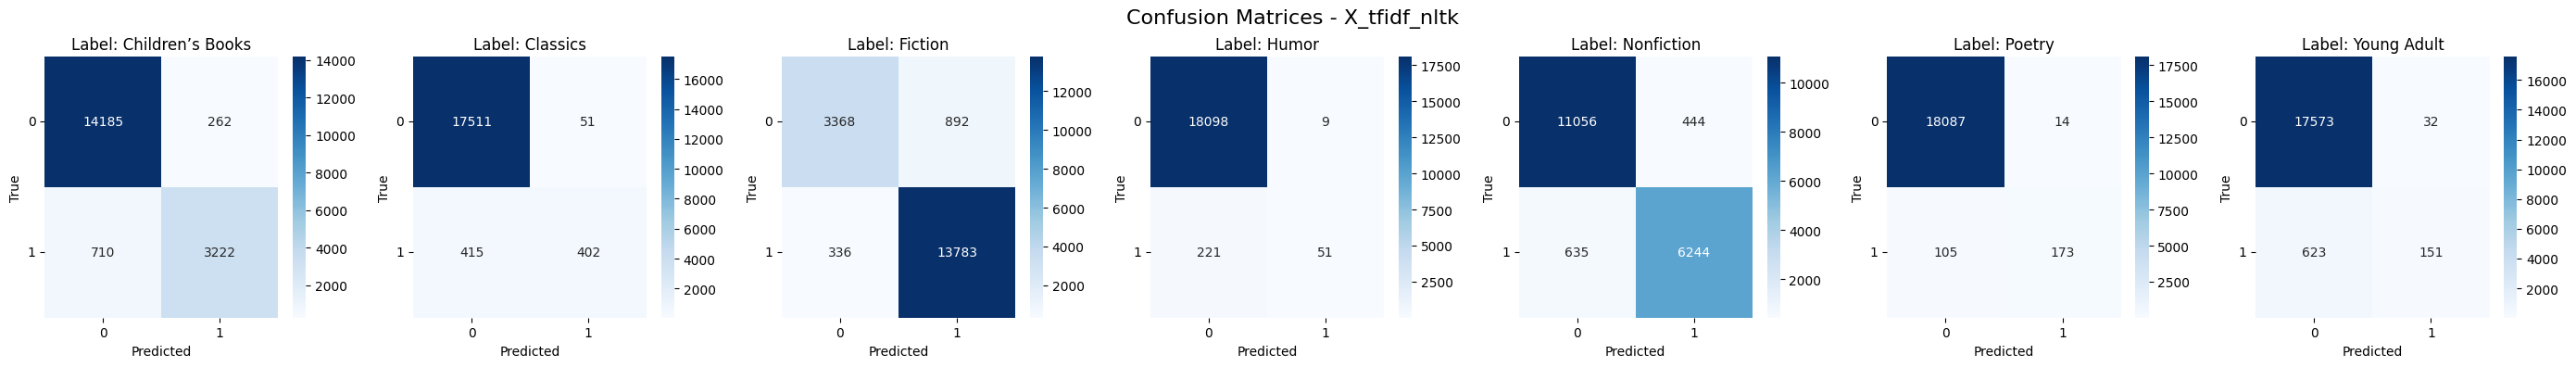

In [ ]:
# For TF-IDF input selection
# You can loop over different vectorizations if needed
X = X_tfidf_nltk  # or X_tfidf_spacy
title = 'X_tfidf_nltk'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(title)
print(f'Train X Size: {X_train.shape}')
print(f'Test X Size: {X_test.shape}')
print(f'Train Y Size: {y_train.shape}')
print(f'Test Y Size: {y_test.shape}')

# Train the classifier
clf = LogisticRegression(max_iter=1000)
multi_classifier = MultiOutputClassifier(clf)
multi_classifier.fit(X_train, y_train)

# Predict
y_pred = multi_classifier.predict(X_test)

# Classification Report
print(f"\nClassification Report - {title}:")
print(classification_report(y_test, y_pred, zero_division=1))

# Confusion Matrices
num_labels = y_test.shape[1]
fig, axes = plt.subplots(1, num_labels, figsize=(4 * num_labels, 4))  # Wider per label
fig.suptitle(f'Confusion Matrices - {title}', fontsize=16)

# Ensure axes is iterable (even for 1 label)
if num_labels == 1:
    axes = [axes]

for i in range(num_labels):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i], labels=[0, 1])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0, 1], yticklabels=[0, 1], ax=axes[i])
    
    axes[i].set_title(f'Label: {mlb.classes_[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Bei Klassen mit wenig Daten tendenziele sehr viel als False Negative bewertet und kaum was als false Positive - Humor, Childrens Book, Poetry, Young Adult

In [ ]:
"""multi_classifier = MultiOutputClassifier(classifier)
multi_classifier.fit(X_train, y_train)
y_pred = multi_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))"""

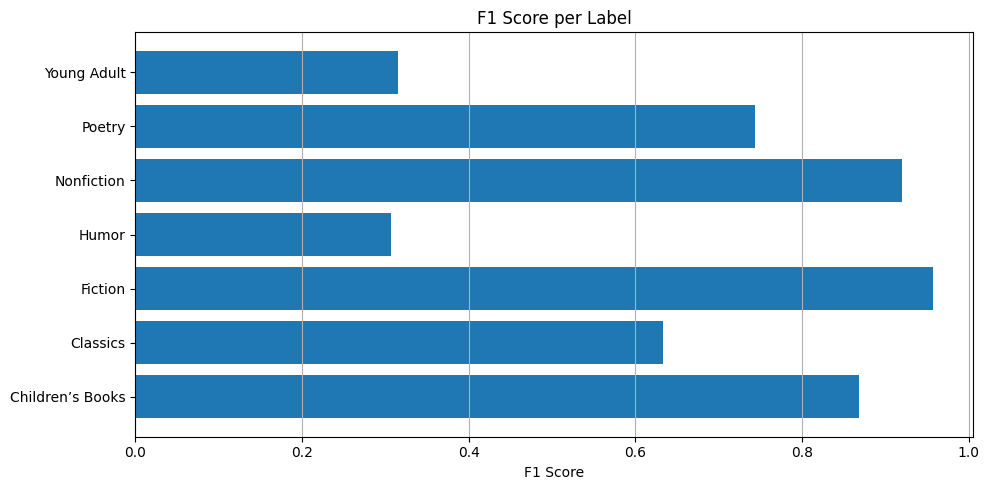

In [27]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# F1 per label
f1s = f1_score(y_test, y_pred, average=None)
labels = mlb.classes_

plt.figure(figsize=(10, 5))
plt.barh(labels, f1s)
plt.xlabel("F1 Score")
plt.title("F1 Score per Label")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


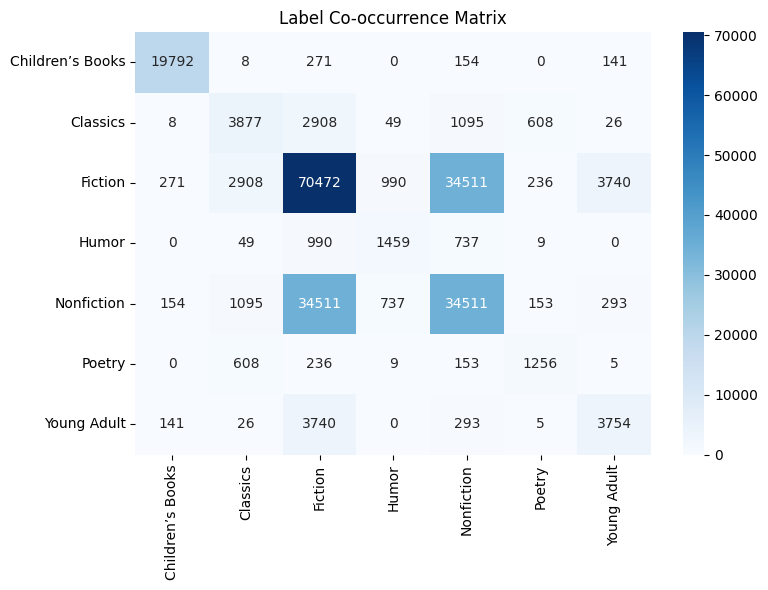

In [28]:
import seaborn as sns
import numpy as np

# Co-occurrence matrix from ground truth
co_matrix = np.dot(y.T, y)
plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=True, fmt='d')
plt.title("Label Co-occurrence Matrix")
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import hamming_loss, accuracy_score

print("Hamming Loss:", hamming_loss(y_test, y_pred))
print("Exact Match Ratio (Subset Accuracy):", accuracy_score(y_test, y_pred))


Hamming Loss: 0.03691324726201488
Exact Match Ratio (Subset Accuracy): 0.8303498558137005


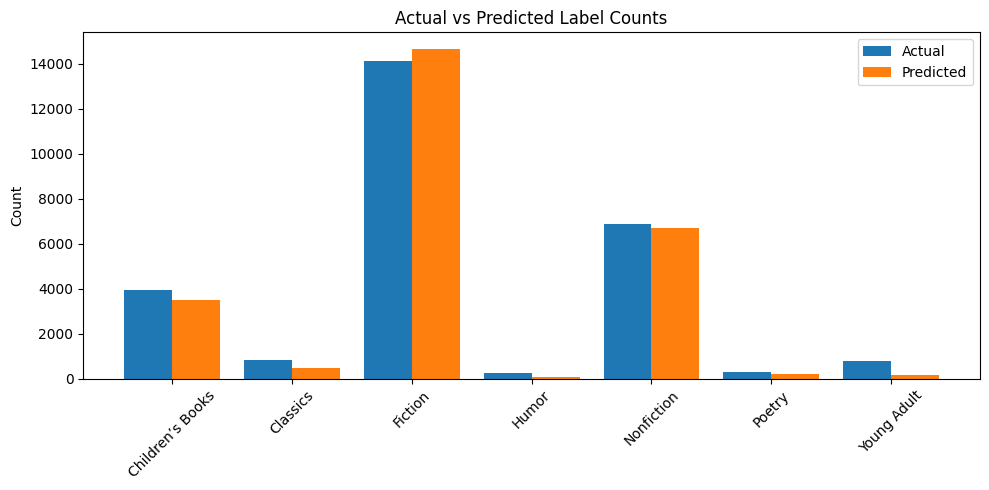

In [30]:
import numpy as np

actual_counts = np.sum(y_test, axis=0)
predicted_counts = np.sum(y_pred, axis=0)

x = np.arange(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, actual_counts, width=0.4, label='Actual')
plt.bar(x + 0.2, predicted_counts, width=0.4, label='Predicted')
plt.xticks(x, labels, rotation=45)
plt.title("Actual vs Predicted Label Counts")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()
